In [584]:
from conex import *
from pymonntorch import *
import torch
import matplotlib.pyplot as plt 

from inputs.patterns import CustomPattern

In [585]:
PATTERN_TRAIN_ITERATIONS = 20 
EACH_PATTERN_TRAIN_NUMBER = 2
GAP_BETWEEN_ITERATIONS = 50
REST_ITERATIONS = 100

I_AMP = 3

In [586]:
patterns = torch.tensor([
    [0, 1, 2, 3, 4],
    [5, 6, 7, 8, 9],
    [10, 11, 12, 13, 14]
], dtype=torch.long)

In [587]:
net = Neocortex(dt = 1)

In [588]:
ca3_e = NeuronGroup(
    net=net,
    size=15,
    behavior=prioritize_behaviors([
        SimpleDendriteStructure(),
        SimpleDendriteComputation(I_tau=2),
        LIF(
            R=10,
            tau=1,
            threshold=-50,
            v_rest=-63,
            v_reset=-65
        ),
        SpikeTrace(tau_s=20),
        NeuronAxon(),
        Fire(),
    ]) | {
        600: EventRecorder(["spikes"]),
        601: Recorder(["I"])
    },
    tag="excitatory"
)

ca3_i = NeuronGroup(
    net=net,
    size=15,
    behavior=prioritize_behaviors([
        SimpleDendriteStructure(),
        SimpleDendriteComputation(),
        LIF(
            R=10,
            tau=1,
            threshold=-50,
            v_rest=-63,
            v_reset=-65
        ),
        SpikeTrace(tau_s=20),
        NeuronAxon(),
        Fire(),
    ]) | {
        600: EventRecorder(["spikes"])
    },
    tag = "inhibitory"
)

In [589]:
ex_to_ex = SynapseGroup(
    net=net,
    src=ca3_e,
    dst=ca3_e,
    behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode="normal(0.01, 0.01)"),
        SimpleDendriticInput(),
        SimpleSTDP(a_minus=0.001, a_plus=0.01, w_min=0, w_max=1),
        ]
    ),
    tag="Proximal"
)

ex_to_inh = SynapseGroup(
    net=net,
    src=ca3_e,
    dst=ca3_i,
    behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode="normal(0.8, 0.1)"),
        SimpleDendriticInput(),
        ]
    ),
    tag="Proximal"
)

inh_to_ex = SynapseGroup(
    net=net,
    src=ca3_i,
    dst=ca3_e,
    behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode="normal(-0.8, 0.1)"),
        SimpleDendriticInput(),
        ]
    ),
    tag="GABA, Proximal"
)

inh_to_inh = SynapseGroup(
    net=net,
    src=ca3_i,
    dst=ca3_i,
    behavior=prioritize_behaviors([
        SynapseInit(),
        WeightInitializer(mode="normal(-0.4, 0.1)"),
        SimpleDendriticInput(),
        ]
    ),
    tag="GABA, Proximal"
)

In [590]:
net.initialize()

for i in range(EACH_PATTERN_TRAIN_NUMBER):
    for pattern in patterns:
        ca3_e.add_behavior(3, behavior=CustomPattern(iters=PATTERN_TRAIN_ITERATIONS, pattern=pattern, amp=I_AMP), initialize=True),
        net.simulate_iterations(PATTERN_TRAIN_ITERATIONS)
        ca3_e.remove_behavior(3)
        net.simulate_iterations(GAP_BETWEEN_ITERATIONS)

Network['Neocortex'](Neurons: tensor(30)|2 groups, Synapses: tensor(900)|4 groups){1:TimeResolution(dt=1,)}
NeuronGroup['excitatory', 'NeuronGroup', 'ng'](15){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=None,)240:SimpleDendriteComputation(I_tau=2,apical_provocativeness=None,distal_provocativeness=None,)260:LIF(R=10,tau=1,threshold=-50,v_reset=-65,v_rest=-63,init_v=None,init_s=None,)340:Fire()360:SpikeTrace(tau_s=20,)380:NeuronAxon(max_delay=1,proximal_min_delay=0,distal_min_delay=0,apical_min_delay=0,have_trace=None,)600:EventRecorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['spikes'],)601:Recorder(variables=None,gap_width=0,max_length=None,auto_annotate=True,tag=None,arg_0=['I'],)}
NeuronGroup['inhibitory', 'NeuronGroup', 'ng'](15){220:SimpleDendriteStructure(Proximal_max_delay=1,Distal_max_delay=1,Apical_max_delay=None,proximal_min_delay=0,distal

In [591]:
net.simulate_iteration(REST_ITERATIONS)

{1: 0.0,
 2: 0.0,
 3: 0.0,
 180: 1.0004043579101562,
 220: 0.0,
 240: 0.0,
 260: 0.0,
 340: 1.0008811950683594,
 360: 0.0,
 380: 0.0,
 400: 0.0,
 600: 0.0,
 601: 0.0}

In [592]:
ca3_e.add_behavior(3, behavior=CustomPattern(iters=5, pattern=patterns[0][:2], amp = I_AMP))
net.simulate_iterations(15)

15xBatch: 1/1 (100%) 15.984ms


15.98358154296875

In [647]:
plt.figure(figsize=(10, 20))

<Figure size 1000x2000 with 0 Axes>

<Figure size 1000x2000 with 0 Axes>

In [648]:
def plotting(title, x_lim, y_lim, sub_plot):
    plt.subplot(3, 1, sub_plot)
    plt.scatter(ca3_e["spikes.t", 0], ca3_e["spikes.i", 0])
    plt.title(title)
    plt.xlabel("iteration")
    plt.ylabel("neuron number")
    plt.xlim(x_lim)
    plt.ylim(y_lim)

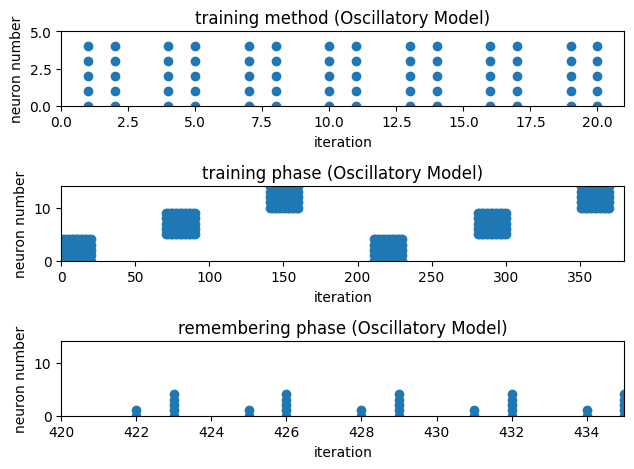

In [649]:
plotting("training method (Oscillatory Model)", x_lim=(0, 21), y_lim=(0, 5), sub_plot=1)
plotting("training phase (Oscillatory Model)", x_lim=(0, 380), y_lim=(0, 14), sub_plot=2)
plotting("remembering phase (Oscillatory Model)", x_lim=(420, 435), y_lim=(0, 14), sub_plot=3)
plt.tight_layout()
plt.savefig("results/combined_image.jpg", bbox_inches="tight", dpi=300)

In [599]:
ca3_e["I", 0].shape

torch.Size([436, 15])

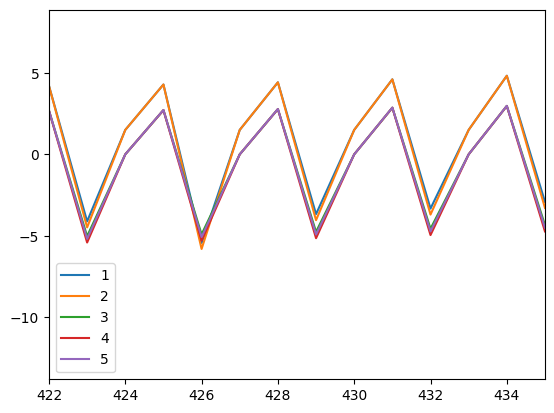

In [620]:
plt.plot(ca3_e["I", 0][:, :5])
plt.xlim((422, 435))
plt.legend(["1", "2", "3", "4", "5"])
plt.show()